In [1]:
import sys
sys.path.append('../')

In [2]:
import pickle
import numpy as np
import pandas as po
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt

In [3]:
from filepaths import fp

In [4]:
df = po.read_csv('../'+fp.imputation_raw)

In [5]:
def find_gaps(x):
    seq = False
    missing_seqs = []
    seq_start_idx = -1
    for i in range(len(x)):
        if seq == False and x[i] == 0:
            seq = True
            seq_start_idx = i
        
        elif seq == True and x[i] != 0:
            seq = False
            if seq_start_idx == -1:
                raise
            missing_seqs.append((seq_start_idx, i))
            seq_start_idx = -1
    
    return missing_seqs

In [96]:
def local_avg(x, value_index, spread=5, P=0.1): # P = 1/(spread*2)
    local_avervage = np.mean(np.array([x[i] for i in range(min(0, value_index-spread), min(value_index+spread, len(x)))]))
    
    values = []
    for k in range(max(0, value_index-spread), min(value_index+spread, len(x))):
        if x[k] < local_avervage: #U_k = 0 condition
            continue 
        values.append(P*local_avervage) 
    
    return sum(values) 

In [97]:
def local_average_impute(x):
    row_mean = np.mean(np.array(x))
    x_filled = x.copy()
    
    gaps = find_gaps(x)
    for gap in gaps:
        len_gap = gap[1] - gap[0]
        
        if len_gap > 1:
            x_filled[gap[0]:gap[1]] = [row_mean]*len_gap # Pre-imputation filling of extended NaNs with row average
        
        for idx in range(gap[0], gap[1]):
            if x[idx] == 0: # using x to read values because we want to see if the original value (before filling with row average)
                x_filled[idx] = local_avg(x_filled, idx)
        
    return x_filled

In [98]:
def impute_row(i):
    x = df.iloc[i][1:].to_list()
    return local_average_impute(x) 

In [99]:
df = po.read_csv('../' + fp.raw_data).sample(frac=1).reset_index(drop = True) # shuffle df so that classes are evenly distributed in train-val-test

In [100]:
df = df.drop(['CONS_NO'], axis = 1)

In [102]:
p = multiprocessing.Pool() 
new_rows = list(tqdm(p.imap(impute_row, list(range(len(df)))), total=len(df)))

100%|██████████| 42372/42372 [01:57<00:00, 359.96it/s]


In [103]:
df_local_avg_impute = po.DataFrame(new_rows)

In [104]:
df_local_avg_impute.columns = df.columns[1:]

In [105]:
df_local_avg_impute

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,2.070000,2.360000,2.360000,2.300000,2.310000,2.420000,2.200000,2.220000,1.750000,1.820000,...,2.96,2.80,5.51,3.07,4.36,2.93,3.33,2.37,3.27,2.62
1,9.450000,10.950000,9.700000,5.287637,4.809950,16.760000,11.370000,4.223649,7.040000,8.100000,...,6.81,8.04,14.89,8.61,20.56,14.72,20.79,12.22,8.98,12.74
2,0.000000,0.000000,2.157585,0.975347,8.320000,3.330132,2.256026,1.422962,8.030000,8.420000,...,5.50,7.69,13.69,6.68,14.37,15.53,17.08,16.11,17.18,11.91
3,0.000000,0.000000,0.363690,0.320875,0.276919,0.231264,0.220752,0.211554,0.203418,0.196153,...,1.21,1.16,1.23,1.16,1.23,1.20,1.21,1.22,1.20,1.19
4,10.809873,10.809873,9.510000,10.680000,10.809873,10.809873,10.809873,10.809873,10.809873,10.809873,...,3.95,4.71,3.37,4.00,4.24,4.98,4.72,3.99,3.79,4.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,0.000000,0.000000,0.000000,0.000000,0.323330,0.196497,0.187565,0.179750,0.172836,0.166664,...,2.56,2.55,2.47,2.62,2.96,2.39,2.72,2.84,2.80,2.86
42368,26.270000,5.270499,4.658881,3.839314,23.370000,24.630000,2.579591,3.918234,3.458765,5.091815,...,13.33,17.78,15.19,17.59,18.37,16.12,14.89,21.21,16.31,16.70
42369,6.970000,7.130000,6.760000,6.710000,4.150000,4.230000,4.930000,6.710000,7.840000,7.370000,...,19.52,25.83,35.09,37.16,36.55,40.31,39.42,35.90,33.67,36.23
42370,44.499462,39.000000,39.000000,40.000000,42.200000,31.800000,44.499462,44.499462,44.499462,26.000000,...,4.40,7.20,1.60,8.40,1.60,1.60,1.60,1.40,1.60,1.60


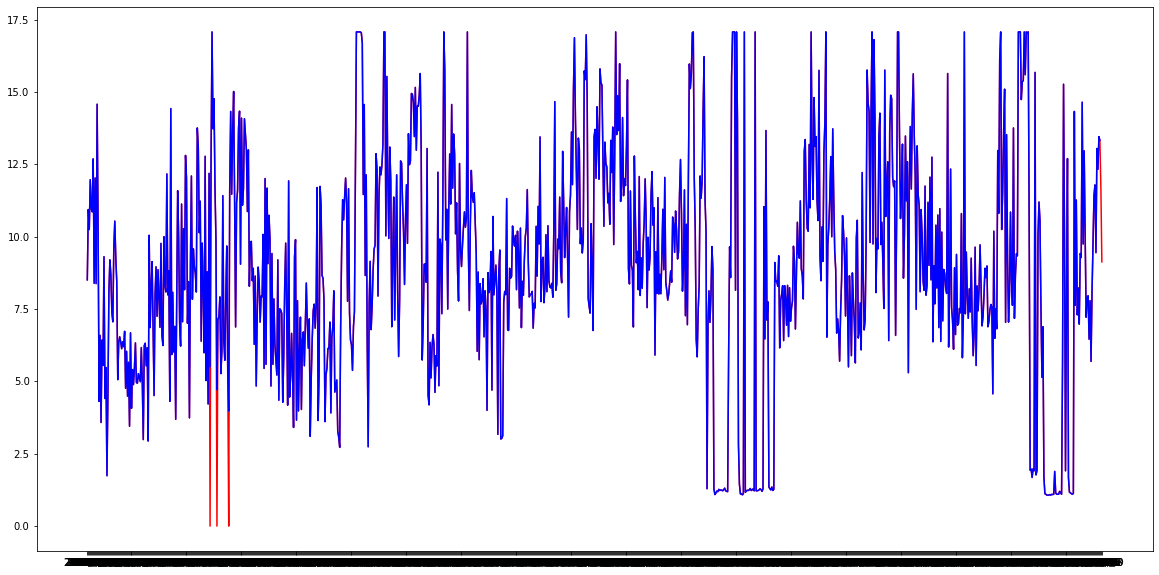

In [106]:
plt.figure(figsize=(20, 10))
plt.plot(df.iloc[2211][1:], color='red')
plt.plot(df_local_avg_impute.iloc[2211][:-2], color='blue')

In [107]:
num_zeros = []
for i in tqdm(range(len(df_local_avg_impute))):
    num_zeros.append(df_local_avg_impute.iloc[i].to_list().count(0))

100%|██████████| 42372/42372 [00:03<00:00, 10916.35it/s]


In [108]:
df_local_avg_impute['num_zeros'] = num_zeros

In [109]:
len(df_local_avg_impute)

42372

In [110]:
df_local_avg_impute['FLAG'] = df['FLAG']

In [127]:
df_0 = df_local_avg_impute[df_local_avg_impute['FLAG'] == 0].reset_index(drop=True) #.sort_values('num_zeros')[:3615]
df_1 = df_local_avg_impute[df_local_avg_impute['FLAG'] == 1].reset_index(drop=True)

In [128]:
# Taking the part of the dataframe with less than 30% missing values for imputation
df_0 = df_0[df_0['num_zeros'] < 0.3*len(df_0.columns)]
df_0

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9,num_zeros,FLAG
0,2.070000,2.360000,2.360000,2.300000,2.310000,2.420000,2.200000,2.220000,1.750000,1.820000,...,5.51,3.07,4.36,2.93,3.33,2.37,3.27,2.62,1,0
1,9.450000,10.950000,9.700000,5.287637,4.809950,16.760000,11.370000,4.223649,7.040000,8.100000,...,14.89,8.61,20.56,14.72,20.79,12.22,8.98,12.74,1,0
2,0.000000,0.000000,2.157585,0.975347,8.320000,3.330132,2.256026,1.422962,8.030000,8.420000,...,13.69,6.68,14.37,15.53,17.08,16.11,17.18,11.91,2,0
3,0.000000,0.000000,0.363690,0.320875,0.276919,0.231264,0.220752,0.211554,0.203418,0.196153,...,1.23,1.16,1.23,1.20,1.21,1.22,1.20,1.19,2,0
4,10.809873,10.809873,9.510000,10.680000,10.809873,10.809873,10.809873,10.809873,10.809873,10.809873,...,3.37,4.00,4.24,4.98,4.72,3.99,3.79,4.74,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38752,18.430000,7.251600,21.180000,19.960000,23.940000,11.644612,25.330000,13.148112,24.490000,25.770000,...,31.00,9.56,39.51,27.30,21.23,22.66,23.50,30.39,1,0
38753,0.000000,0.000000,0.000000,0.000000,0.323330,0.196497,0.187565,0.179750,0.172836,0.166664,...,2.47,2.62,2.96,2.39,2.72,2.84,2.80,2.86,4,0
38754,26.270000,5.270499,4.658881,3.839314,23.370000,24.630000,2.579591,3.918234,3.458765,5.091815,...,15.19,17.59,18.37,16.12,14.89,21.21,16.31,16.70,0,0
38755,6.970000,7.130000,6.760000,6.710000,4.150000,4.230000,4.930000,6.710000,7.840000,7.370000,...,35.09,37.16,36.55,40.31,39.42,35.90,33.67,36.23,3,0


In [129]:
df_imp = po.concat([df_0, df_1], axis=0, ignore_index=True).sample(frac=1).reset_index(drop=True)
df_imp

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9,num_zeros,FLAG
0,1.971900,8.32000,8.090000,4.380000,6.970000,7.720000,10.890000,3.100000,5.160000,2.880000,...,6.16,5.80,13.153972,8.890000,11.74000,7.22000,4.400000,5.72,5,0
1,4.520000,3.54000,6.040000,6.000000,3.450000,5.390000,8.440000,7.700000,6.680000,6.690000,...,0.00,0.00,0.000000,0.000000,0.00000,0.00000,0.000000,0.00,80,0
2,0.000000,0.00000,0.000000,0.000000,1.053652,0.681835,0.650842,0.623724,0.599734,0.578315,...,6.55,8.97,10.660000,12.250000,12.60064,12.60064,11.880000,8.49,4,0
3,12.140000,11.84000,10.480000,14.800142,12.240000,10.760000,13.420000,11.820000,12.600000,11.110000,...,13.65,10.38,13.550000,14.800142,12.42000,12.17000,14.800142,12.11,0,0
4,0.940000,1.07000,0.192000,1.220000,1.020000,0.980000,4.420000,0.930000,1.040000,1.110000,...,3.28,3.58,1.950000,1.840000,1.77000,2.76000,1.610000,5.18,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37685,4.282819,4.14196,4.039058,3.771511,3.619586,3.401066,3.246472,3.111202,2.991541,2.884700,...,9.72,6.84,6.990000,7.100000,6.20000,9.39000,6.810000,7.99,0,0
37686,0.000000,0.00000,5.817557,5.143935,4.560132,4.017139,3.834541,3.674769,3.533432,3.407238,...,16.37,12.69,20.000000,19.950000,18.84000,19.29000,16.820000,15.42,2,0
37687,0.000000,0.00000,0.000000,0.501889,0.386983,0.302332,0.288590,0.276565,0.265928,0.256431,...,3.04,3.57,2.850000,2.570000,2.32000,2.63000,2.800000,2.08,17,0
37688,0.000000,0.00000,0.000000,0.000000,0.799578,0.514557,0.491168,0.470702,0.452599,0.436434,...,8.67,5.19,6.920000,8.707173,7.95000,8.00000,6.800000,6.50,4,0


In [130]:
df_imp['FLAG'].value_counts()

0    34075
1     3615
Name: FLAG, dtype: int64

In [132]:
df_imp.to_csv('../data/processed/imputation/local_average.csv', index=False)

In [4]:
df = po.read_csv('../'+fp.imputation_raw)
df_imp = po.read_csv('../data/processed/imputation/local_average.csv')

In [5]:
df_imp[df_imp['2016/9/7'] == 43.84000]

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9,num_zeros,FLAG
20431,15.88,13.71,13.58,13.360000,14.740000,16.540000,13.070000,17.710000,12.040000,17.32000,...,49.13026,40.96,35.15,31.93,42.36,43.84,49.13026,34.73,1,0
33808,0.00,0.00,0.00,8.569871,6.927364,5.232233,4.994404,4.786304,4.602215,4.43785,...,53.00000,42.64,41.67,31.42,43.05,43.84,41.42000,40.83,83,0


In [6]:
df[df['2016/9/7'] == 43.84000]

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9,num_zeros,FLAG
28,15.88,13.71,13.58,13.36,14.74,16.54,13.07,17.71,12.04,17.32,...,49.13026,40.96,35.15,31.93,42.36,43.84,49.13026,34.73,147,0


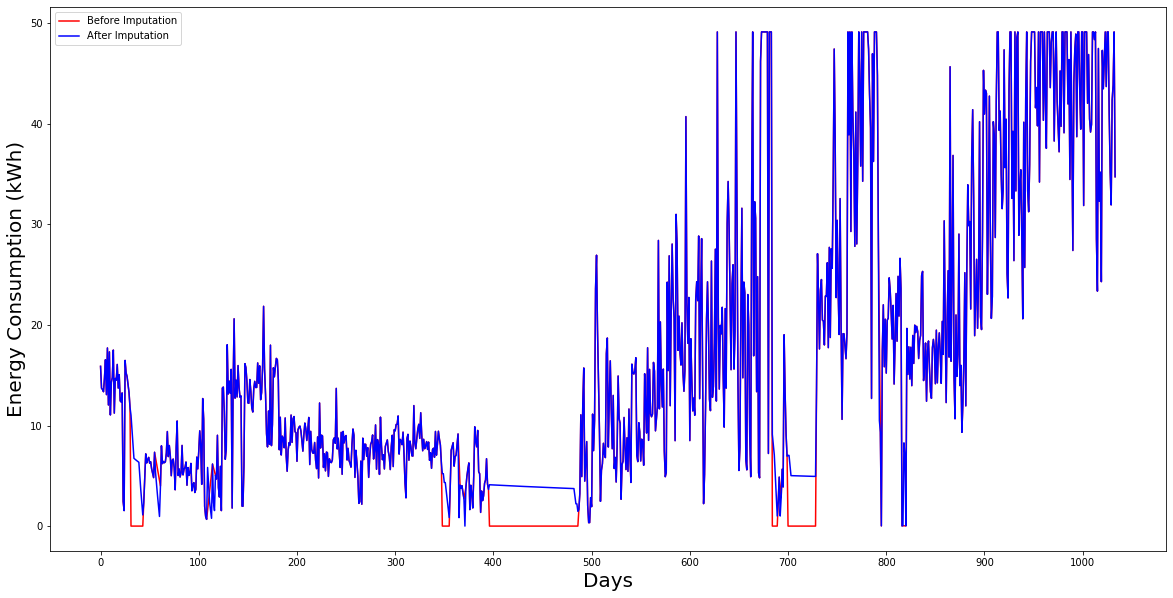

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(df.iloc[28][:-2], color='red')
plt.plot(df_imp.iloc[20431][:-2], color='blue')
plt.xticks(range(0, len(df.iloc[28][:-2]), 100), range(0, len(df.iloc[28][:-2]), 100)) 
plt.xlabel('Days', fontsize=20)
plt.ylabel('Energy Consumption (kWh)', fontsize=20)
plt.legend(['Before Imputation', 'After Imputation'])
plt.savefig('../plots/impute/local_average.png')